<a href="https://colab.research.google.com/github/ngotancuong/mse.python/blob/main/Baitap01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BÀI HƯỚNG DẪN TÌM HIỂU VỀ EDA, PHÂN TÍCH DỮ LIỆU CHUỖI THỜI GIAN VÀ CÁC DỰ BÁO DỰA VÀO MÔ HÌNH SARIMAX

Cuộc thi này do Walmart tài trợ có tên là Dự báo M5. Sử dụng dữ liệu bao gồm khoảng 30.000 mặt hàng khác nhau trong gần 1900 ngày. Mục tiêu là dự báo doanh số bán hàng trong 28 ngày tới. Phân bố ở ba Tiểu bang Hoa Kỳ (California, Texas và Wisconsin).

### Import các thư viện cần thiết

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # các hàm liên quan đại số tuyến tính, xử lý các Tensor
import pandas as pd # module hỗ trợ xử lý dữ liệu dạng Series, DataFrame,..., xử lý file ví dụ CSV file I/O (sử dụng pd.read_csv)
import matplotlib.pyplot as plt # module hỗ trợ vẽ biểu đồ

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Tắt cảnh báo về tương thích phiên bản 
# Example FutureWarning: `distplot` is a deprecated function and will be removed in a future version
import warnings
warnings.filterwarnings("ignore")

# Đọc các Datasets vào bộ nhớ chính
sell_prices_df = pd.read_csv('https://media.githubusercontent.com/media/ngotancuong/mse.python/master/data/input/sell_prices.csv')
train_sales_df = pd.read_csv('https://media.githubusercontent.com/media/ngotancuong/mse.python/master/data/input/sales_train_validation.csv')
calendar_df = pd.read_csv('https://media.githubusercontent.com/media/ngotancuong/mse.python/master/data/input/calendar.csv')
submission_file = pd.read_csv('https://media.githubusercontent.com/media/ngotancuong/mse.python/master/data/input/sample_submission.csv')

print("Import dataset thành công. Dữ liệu đã được nạp vào 4 Data Frame")

Import dataset thành công. Dữ liệu đã được nạp vào 4 Data Frame


#### Mô tả các Dataset:

Các file dataset đã import vào có những nội dung như sau

* `calendar_df.csv` - Chứa thông tin về ngày sản phẩm được bán và cũng chứa thông tin về các ngày lễ và các dịp đặc biệt.
* `train_sales_df.csv` - Chứa dữ liệu lịch sử bán hàng hàng ngày tại từng cửa hàng trong khoảng 1900 ngày [d_1 - d_1913] 
* `submission_file.csv` - Những file submit đúng định dạng, bao gồm product ids, column ids cho việc dự báo doanh thu bán hàng 28 ngày kế tiếp. 
* `sell_prices_df.csv` - Bao gồm thông tin về giá sản phẩm được bán tại từng cửa hàng mỗi ngày.
* `sales_train_evaluation.csv` - Bao gồm doanh số [d_1 - d_1941] (dùng cho việc khen thưởng, tuyên dương nhân viên)

### Kiểm tra vài thông tin về Datasets



In [3]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [4]:
train_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [5]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


Chúng ta có thể thấy `sell_prices_df` chứa đến 6.841.121 giao dịch ở cấp độ cửa hàng. `train_sales_df` chứa 30.490 sản phẩm khác nhau. Và `calendar_df' có thể dùng để phân tích theo chuỗi thời gian các sản phẩm đã bán.

### EDA (Exploratory Data Analysis) - Phân tích khám phá dữ liệu

#### Các câu hỏi về phân phối sản phẩm và hành vi theo thời gian

In [23]:
# Lấy ra 3 dòng đầu tiên của Data Frame để xem nó chứa dữ liệu gì để khai thác
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales_all_days,avg_sales_all_days,median_sales_all_days
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,3,0,1,1,600,0.313643,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,493,0.257710,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,1,1,288,0.150549,0.0


In [24]:
# Trả về danh sách các tiêu đề cột có chứa tiền tố 'd_' (tức là cột ngày)
d_cols = [c for c in train_sales_df.columns if 'd_' in c]
# Tổng số ngày bán hàng được tính là sum của các cột (axis=1 là đếm ngang)
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
# train_sales_df[d_cols] là dataframe chứa các cột và dòng dữ liệu ngày bán hàng
# Hàm mean là tính giá trị trung bình
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)
# Hàm median là tính giá trị trung vị
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

#### Biểu đồ doanh số sản phẩm theo categoty

In [26]:
# Data Frame gom nhóm sản phẩm theo category và đếm số lượng sản phẩm có phát sinh giao dịch trong category tương ứng
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
# Hàm vẽ biểu đồ hình bánh
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Số lượng sản phẩm theo Category có phát sinh giao dịch')
fig.show()

Theo biểu đồ ta thấy Thực phẩm là mặt hàng có nhiều mã sản phẩm bán ra nhất (chiếm 47.1%), tiếp theo là đồ gia dụng và sau đó là đồ theo sở thích.

In [12]:
#Dataframe chứa tổng doanh số theo bang
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()

fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Doanh số sản phẩm theo bang')
fig.show()

Tổng doanh số hàng bán ở Bang CA là cao nhất (43.6%), kế tiếp là Texas và Wisconsin

In [13]:
# Đếm số lượng sản phẩm có phát sinh giao dịch theo từng category và lưu vào data frame
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
# Tính tổng doanh số theo category và state, lưu vào data frame
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

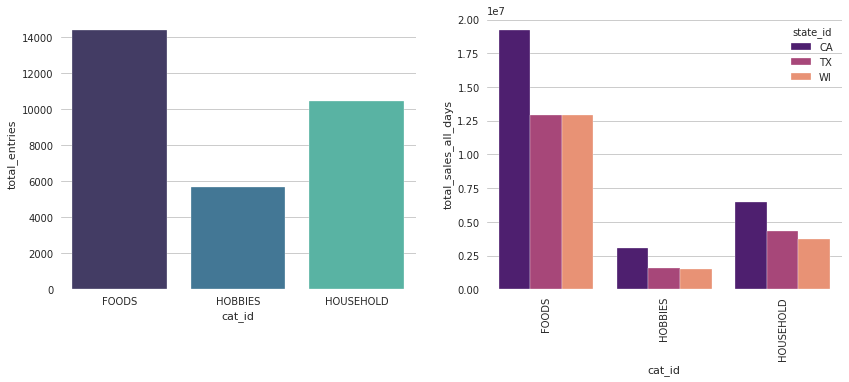

In [ ]:
# Dùng thư viện seaborn để vẽ biểu đồ hình cột 
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

In [27]:
# Đếm sản phẩm có phát sinh giao dịch gom nhóm theo category và state, đưa vào data frame
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
# Vẽ biểu đồ hình cột
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Sản phẩm có phát sinh giao dịch gom nhóm theo Category và State")
fig.show()

#### Biểu đồ phân phối các mặt hàng theo Department và Store_id

In [39]:
# Gom nhóm Deparment, Store, State, Category. Sau đó tính tổng doanh số toàn thời gian.
# Bắt đâu tính tổng từ cột có index=6 ( tức là cột d_1 tới cuối)
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[6:]].sum().reset_index()
# Sắp xếp kết quả tính toán theo giá trị từ cao xuống thấp.
df = df.sort_values('total_sales_all_days', ascending=False)
# print(df['d_50'])

In [41]:
x_dept = df['dept_id']
x_store = df['store_id']

def items_sold_per_days(x_spec,title_text, title):
    
    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier
    
    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown), 
            title (title of the plot)
            
    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific 
    number of days        
    '''
    
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']
    # Khởi tạo và nạp giá trị dropdown list
    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]
    # Khởi tạo instance vẽ lưới cơ sở
    fig = go.Figure()
    # Khởi tạo giá trị trục x, y,...
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))
    # Cập nhật layout của biểu đồ như tiêu đề, kích thước, giá trị dropdown list đã chọn
    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 
    # Chèn chú thích cho dropdown list
    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()
# Gọi hàm và truyền tham số để vẽ biểu đồ
items_sold_per_days(df['store_id'], 'Doanh số theo Store', 'Stores')
items_sold_per_days(df['state_id'], "Doanh số theo State", 'States')

#### Mặt hàng cụ thể Bán chạy nhất?

In [43]:
# Doanh số sản phẩm bán chạy nhất, xếp theo giá trị giảm dần
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

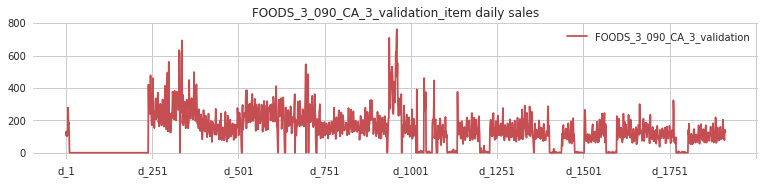

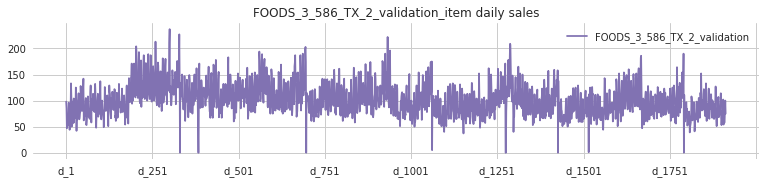

In [50]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols].T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    # Chèn chú thích vào biểu đồ
    plt.legend()
    plt.show()
# Gọi hàm vẽ biểu đồ, truyền tham số là id của 2 sản phẩm có doanh số cao nhất
plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

#### Sản phẩm bán chạy nhất trong mỗi Category

In [51]:
# Tính tổng doanh số theo gom nhóm id, category, store đưa vào data frame, xấp thứ tự giảm dần
df_agg = pd.DataFrame(train_sales_df.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days'].sum().sort_values(ascending=False))
df_agg = df_agg.reset_index()
df_agg.head(3)

,id,cat_id,store_id,total_sales_all_days
0,FOODS_3_090_CA_3_validation,FOODS,CA_3,250502
1,FOODS_3_586_TX_2_validation,FOODS,TX_2,192835
2,FOODS_3_586_TX_3_validation,FOODS,TX_3,150122


In [53]:
# In ra 3 sản phẩm bán chạy nhất theo từng Category
print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_118_CA_3_validation', 'HOUSEHOLD_1_459_CA_3_validation', 'HOUSEHOLD_1_334_CA_3_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_1_234_CA_3_validation', 'HOBBIES_1_348_CA_1_validation', 'HOBBIES_1_371_CA_1_validation']


In [18]:
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))
# Hàm vẽ biểu đồ dựa theo tham số là mã sản phẩm, ngày bắt đầu, ngày kết thúc, bước nhảy
def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    """
    plots sample sales data with selection point and ending point specified, along with
    samples_pick point that specifies the samples picked after specified intervals
    
    input: spec_id (item_id or id), sm_start (sample_start), sm_end(sample_end),
    samples_pick (samples picked after how many intervals)
    
    returns: outputs a graph of sample points plotted against daily sales data d_1 to d_1913
    """
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    x1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]
    y1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    #this conversion for regplot only
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    #sns.lineplot(x=x1, y=y1, ax=ax1)
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)
    ax1.set_ylabel("Number of Sales")
    ax1.set_xlabel("Days")

    ax1.set_xticks(x1[::samples_pick])
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    fig.tight_layout()
    plt.show()

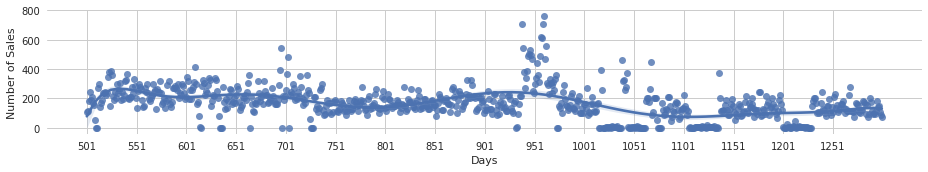

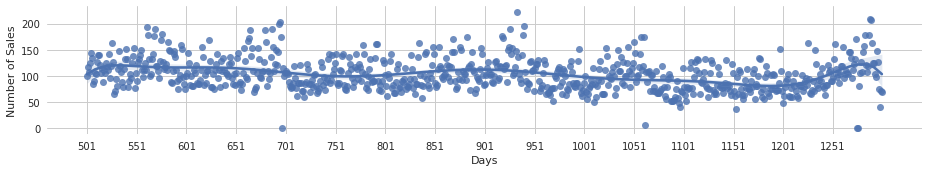

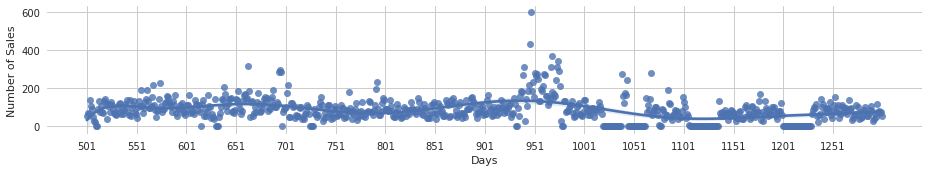

In [55]:
# Gọi phương thức vẽ biểu đồ với ngày bắt đầu là ngày thứ 500, kết thúc là ngày 1300, bước nhảy mặc định là 50
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)

### Những câu hỏi về doanh thu bán hàng?

In [20]:
# Show ra 3 sản phẩm đầu tiên trong bảng dữ liệu
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [58]:
# Tạo một cột mới chứa Category tách ra từ cột item_id, lấy giá trị từ vị trí 0 tới dấu _ thì dừng
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

#### Phân bổ giá giữa các Category

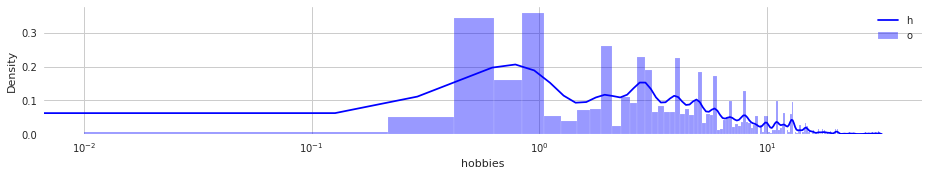

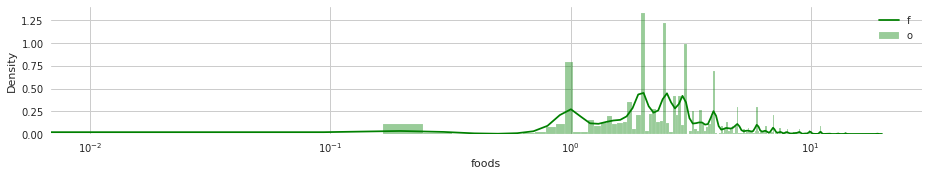

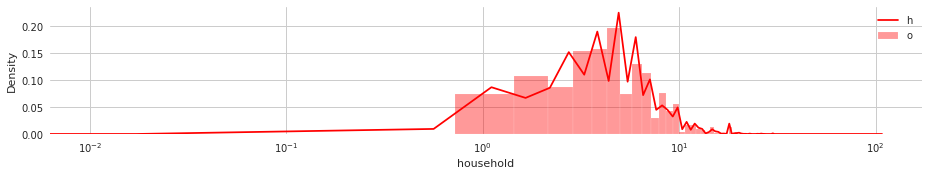

In [60]:
sns.set_style('whitegrid')
#plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )
    # Hàm distplot thể hiện sự phân bổ dữ liệu, cụ thể ở đây là phân bổ doanh thu theo category và chia theo số lượng cột = tham số bins
    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend(label)
    plt.show()
# Gọi hàm vẽ biểu đồ, tuyền tham số   
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

#### Loại bỏ các yếu tố ngoại lai để theo dõi phân phối giá? => Làm sạch dữ liệu
#### **Phương pháp phần tư**

In [82]:
def remove_outliers(df):
    
    '''
    removes the outliers in continous features using quartile ranges
    
    inputs: df(df specified with continous features along side categorical features)
    returns: df with removed outliers
    '''
    Q1=df.quantile(0.25)
    print(Q1)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final

df = sell_prices_df[['category', 'sell_price']]
df = remove_outliers(df)

sell_price    2.18
Name: 0.25, dtype: float64


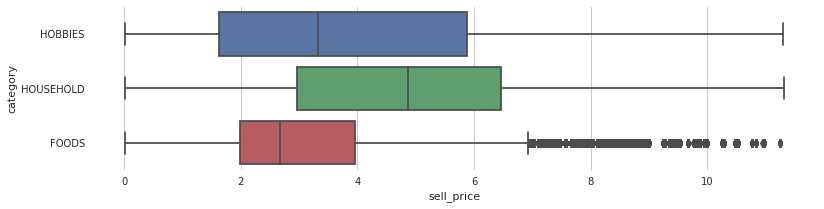

In [81]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.boxplot(y=df['category'], x=df['sell_price'])
plt.show()

#### Sư phân bổ doanh số vào các ngày trong tuần và các dịp đặc biệt?

In [83]:
calendar_df.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,days,events_names,events_types
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29,NaN,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30,NaN,NaN
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31,NaN,NaN


In [84]:
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

In [64]:
calendar_df.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

In [65]:
#Making in and including a new entry of days as well as merging the events_1 and event_2 into
# a single new events_names and types category

calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

#### SNAP_CA, SNAP_TX, SNAP_WI là gì?

In [67]:
df = calendar_df.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

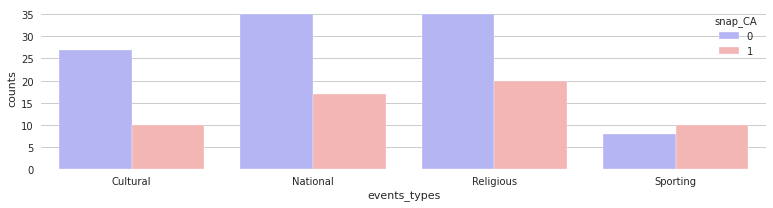

In [68]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show()

In [69]:
df = calendar_df.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')

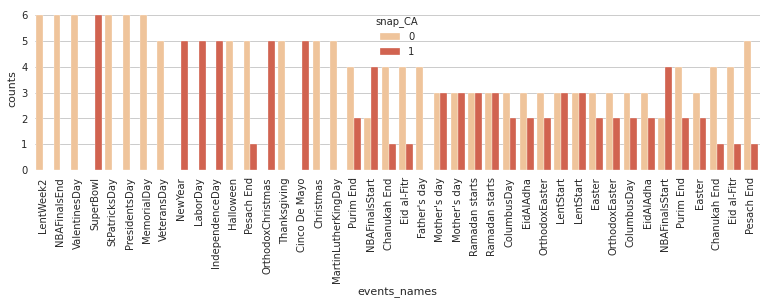

In [70]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()

In [71]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner',  
                                            left_index=True, right_index=True, 
                                            validate="1:1")

In [72]:
df = train_sales_prices_df.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')
df = df.sort_values(by='total_revenue', ascending=False)

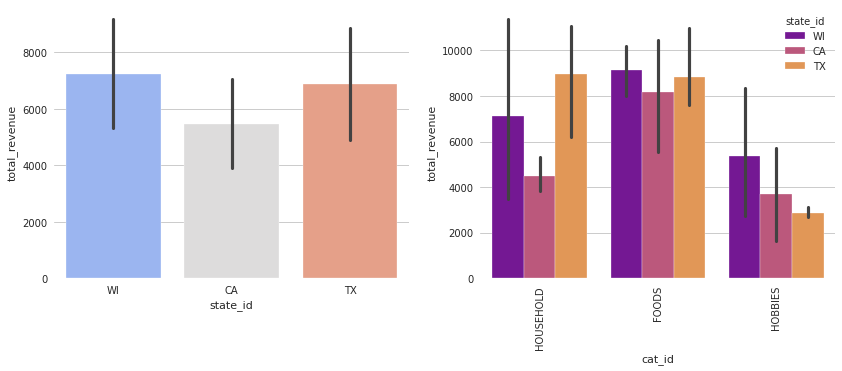

In [73]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

### Hành vi trên TimeSeries & Analysis?

#### Phân phối Tổng doanh số so với Product_id theo thời gian?

In [85]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

In [86]:
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

In [87]:
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

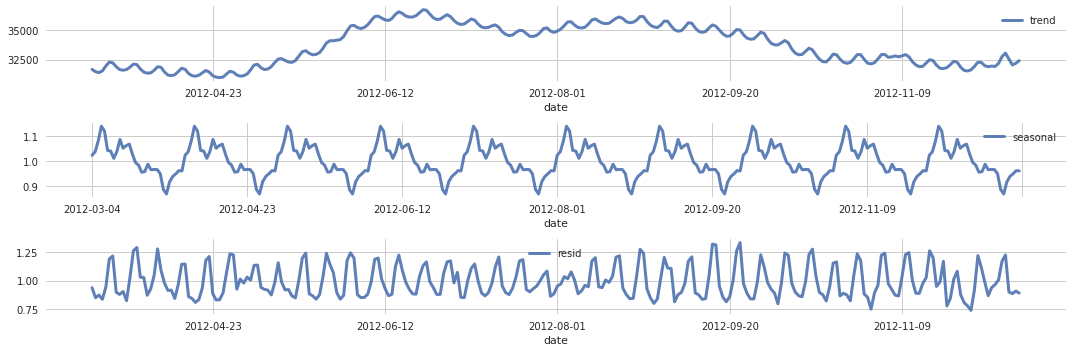

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

In [90]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [91]:
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

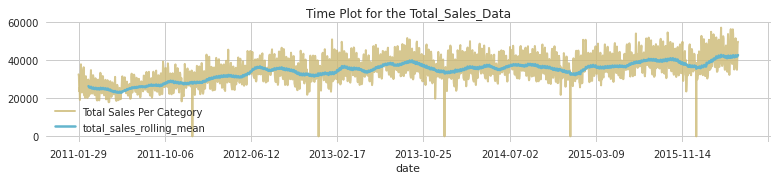

In [92]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

In [93]:
#finding the product_ids of 25 most sold units
train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,FOODS_3_090_CA_3_validation,250502
1,FOODS_3_586_TX_2_validation,192835
2,FOODS_3_586_TX_3_validation,150122
3,FOODS_3_586_CA_3_validation,134386
4,FOODS_3_090_CA_1_validation,127203


In [94]:
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum().sort_values(ascending=False)

state
TX    1233196
CA    1005717
WI     470367
Name: total_sales, dtype: int64

In [95]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

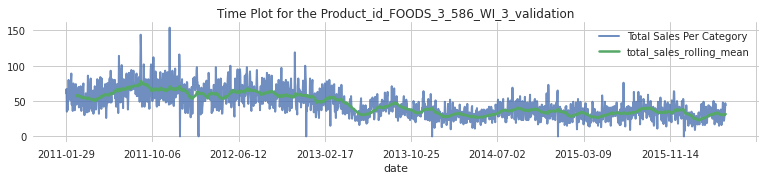

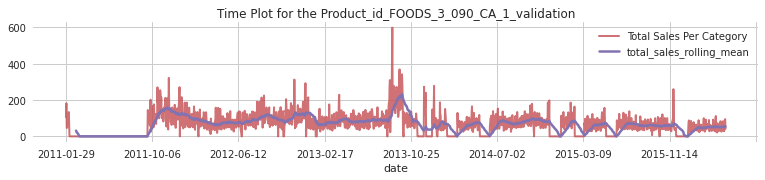

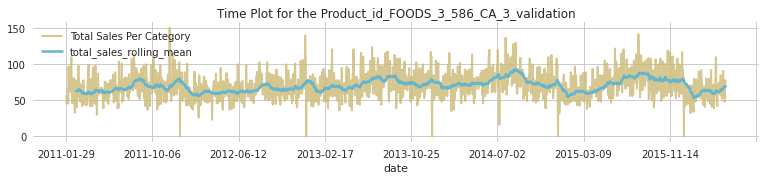

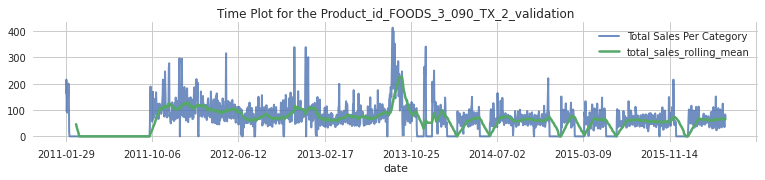

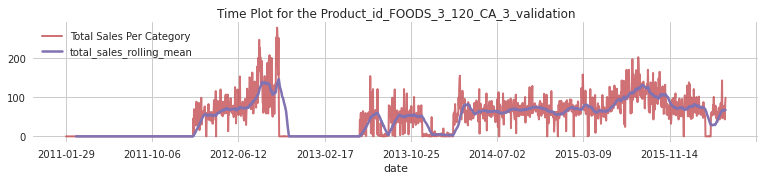

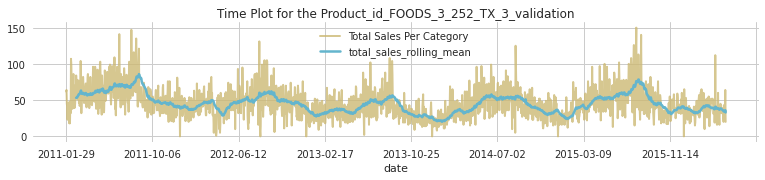

In [96]:
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")

#### Phân phối Tổng Doanh số đối với mỗi Category?

In [97]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [98]:
train_sales_cal_df.head(2)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634


In [99]:
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''
    fig = go.Figure()
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

plotly_time_plot_markers(train_sales_cal_df, 'Category')  

#### Phân phối Tổng doanh số đã bán cho mỗi tiểu bang?

In [100]:
train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum().T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [101]:
#train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

,CA,TX,WI
date,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309
...,...,...,...
2016-04-20,15148,9600,10595
2016-04-21,14488,9602,10943
2016-04-22,17095,10615,12807


In [102]:
from plotly.subplots import make_subplots

def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

plotly_time_plot_rolling(train_sales_cal_df, 'State')

In [103]:
#referring to the solution provided at https://stackoverflow.com/questions/43223615/join-dataframes-one-with-multiindex-columns-and-the-other-without

train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum().T\
              .join(pd.concat([calendar_df.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(2)

,"(CA, FOODS)","(CA, HOBBIES)","(CA, HOUSEHOLD)","(TX, FOODS)","(TX, HOBBIES)","(TX, HOUSEHOLD)","(WI, FOODS)","(WI, HOBBIES)","(WI, HOUSEHOLD)",dates
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691,2011-01-29
d_2,9862,1561,2382,7030,870,1730,5866,926,1522,2011-01-30


In [104]:
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
#train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
#train_sales_cal_df = 
df_CA = train_sales_cal_df.set_index('dates')[select_cols_ca]
df_TX = train_sales_cal_df.set_index('dates')[select_cols_tx]
df_WI = train_sales_cal_df.set_index('dates')[select_cols_wi]

#df_CA.columns = [col[1] for col in df_CA.columns]
#df_TX.columns = [col[1] for col in df_TX.columns]
#df_WI.columns = [col[1] for col in df_WI.columns]

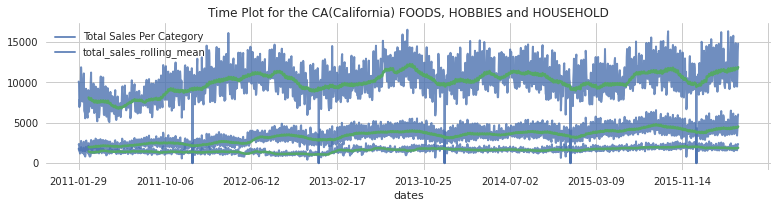

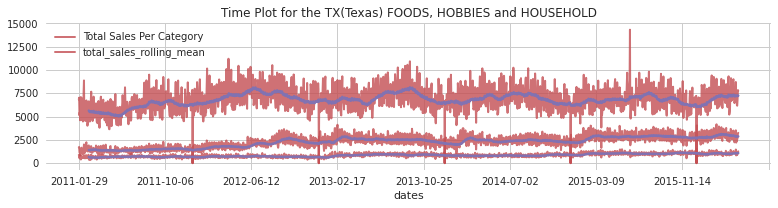

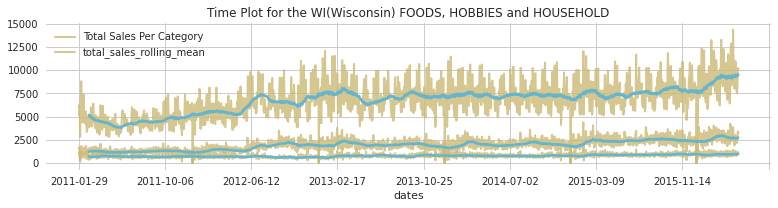

In [105]:
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

In [106]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

In [107]:
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

In [108]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

In [109]:
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

In [110]:
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()
    df.columns = ['item_id', 'sales_count']
    df = df.set_index('item_id')
    item_type = [c for c in df.index if category in c]
    df = df[df.index.isin(item_type)]
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )

Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


#### Phân phối Total Sales Vs Store_ID?

In [111]:
train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum()\
                                                .T.merge(calendar_df.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')

In [112]:
train_sales_cal_df.head(2)

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198


In [113]:
#PLOT one by one to avoid memory overload

#plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
#plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

#### Phân phối Sales theo các ngày đặc biệt như lễ và cuối tuần?

In [114]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [115]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(2)

,date,FOODS,HOBBIES,HOUSEHOLD,month,day,year,weekday
0,2011-01-29,23178,3764,5689,1,29,2011,Saturday
1,2011-01-30,22758,3357,5634,1,30,2011,Sunday


In [116]:
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')
df_hob = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')

In [117]:
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()

In [118]:
heatmap_plot_dates(df_food, 'FOODS')
heatmap_plot_dates(df_hob, 'HOBBIES')
heatmap_plot_dates(df_house, 'HOUSEHOLD')

### Dự báo theo Time series

#### Stationary Time Series

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'],
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1")
train_sales_cal_df['avg_sales'] = train_sales_cal_df.mean(axis=1, numeric_only=True)

In [ ]:
print(train_sales_cal_df['avg_sales'])

d_1       1.070220
d_2       1.041292
d_3       0.780026
d_4       0.833454
d_5       0.627944
            ...   
d_1909    1.159167
d_1910    1.149000
d_1911    1.328862
d_1912    1.605838
d_1913    1.633158
Name: avg_sales, Length: 1913, dtype: float64


In [ ]:
##train_sales_cal_df = train_sales_cal_df[['total_sales']]
##train_sales_cal_df = train_sales_cal_df.reset_index()
##train_sales_cal_df = train_sales_cal_df.set_index('date')
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df.rename(columns={'index': 'daysnum'}, inplace=True)
train_sales_cal_df = train_sales_cal_df.set_index('date')#.asfreq(freq ='d')
train_sales_cal_df.head(2)

,daysnum,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,...,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation,avg_sales
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,d_1,0,0,0,0,0,0,0,12,2,...,14,1,0,4,0,0,0,0,0,1.070220
2011-01-30,d_2,0,0,0,0,0,0,0,15,0,...,11,1,0,4,0,0,6,0,0,1.041292


In [ ]:
train_sales_cal_df.index = pd.to_datetime(train_sales_cal_df.index)
type(train_sales_cal_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
def time_series_stationary_test(df):
    
    '''
    returns time_series plots along with rolling mean plot, standard_dev calculated plot
    and results of the Dickey_Fuller Test performed on time_series df
    
    inputs: df (time_series based df)
    
    returns : time_series plot, rolling_mean plot, std_plot and Dickey_Fuller Test Statistics
              performed on time_series
    '''
    #df_filter = df.loc[df['id'] == series_ids][d_cols]
    #df_filter = df.loc[df['id'] == series_ids]['sold']
    #df_filter = pd.Series(df_filter.values.flatten())
    
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    rolling_mean = df.rolling(window=7).mean()
    rolling_std =  df.rolling(window=7).std()
    
    #plotting the points
    original_series = df.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, color=next(color_cycle), label='original_series', ax=ax1)
    mean_series = rolling_mean.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = 'o', color=next(color_cycle), label='rolling_mean', ax=ax1)
    std_series = rolling_std.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = '*' , color=next(color_cycle), label='rolling_std', ax=ax1)
    
    ax1.legend(['Original_Series', 'Mean_Series', "Std_Series"])
    plt.show()
    
    #Performing a Dickey-Fuller Test
    print("\n============++++==========\n")
    print("Results of the Dickey_Fuller Test")
    result = adfuller(df, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('No of lags: %f' %result[2])
    print('No of Obs used for ADF Calculation & Critical Values: %f' %result[3])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    #output = pd.Series(result[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in result[4].items():
    #    output['Critical Value (%s)'%key] = value
    #print (output)

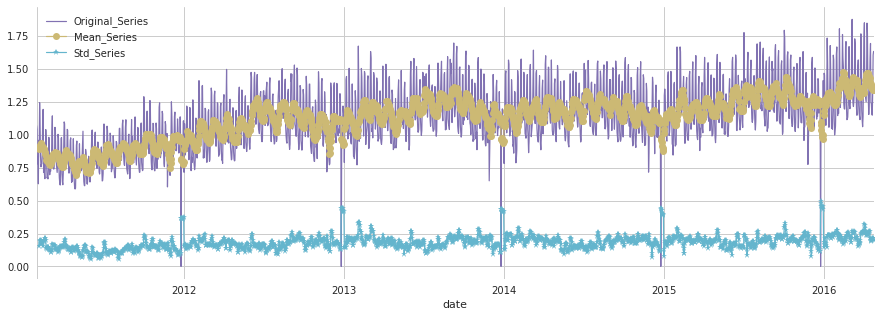


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -1.565373
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1886.000000
p-value: 0.500960
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
time_series_stationary_test(train_sales_cal_df[['avg_sales']])

#### Phương pháp tạo Time Series Stationary

#### **Differencing**

In [ ]:
df_log_diff = np.log(train_sales_cal_df[['avg_sales']]) - np.log(train_sales_cal_df[['avg_sales']]).shift()
#df['sold'] = df_log_diff
#df['sold'] = df['sold'].dropna()
df_log_diff = df_log_diff.dropna()

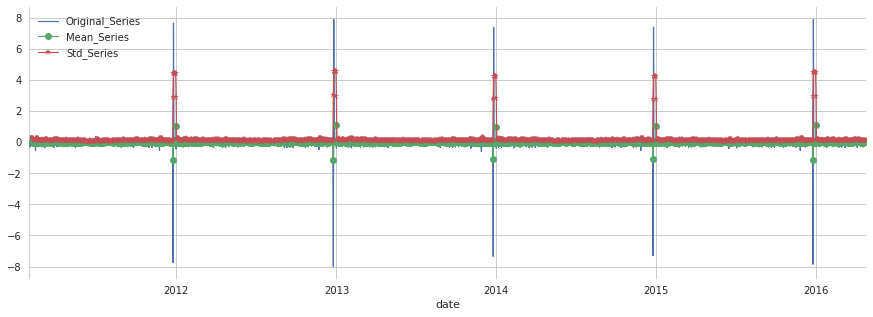


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -16.908187
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1885.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
time_series_stationary_test(df_log_diff)

#### **Decomposition**

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):
    
    '''
    returns the trend, seasonality, and residual components decomposition of time_Series and
    plots the results 
    
    inputs: df(time_series df along with sales specified), model_specified (whether to use
            additive or multiplicative), period (number of days where seasonality 
            is to be observed)
    returns: decomposition plots along with decomposition components, in trend, seasonality
    and residuals
    '''

    df_decomposition = seasonal_decompose(
                               x=df, 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 24))

    df.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax1)
    est_trend.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax2)
    est_seasonal.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax3)
    est_residual.plot(figsize=(14, 8) ,
                 alpha=0.6, 
                 lw=3, style = 'o', ax = ax4)

    fig.tight_layout()
    plt.show()
    
    return est_trend, est_seasonal, est_residual

#sample_time_s1 = train_sales_cal_df[400:700]
#est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 'multiplicative', 15)

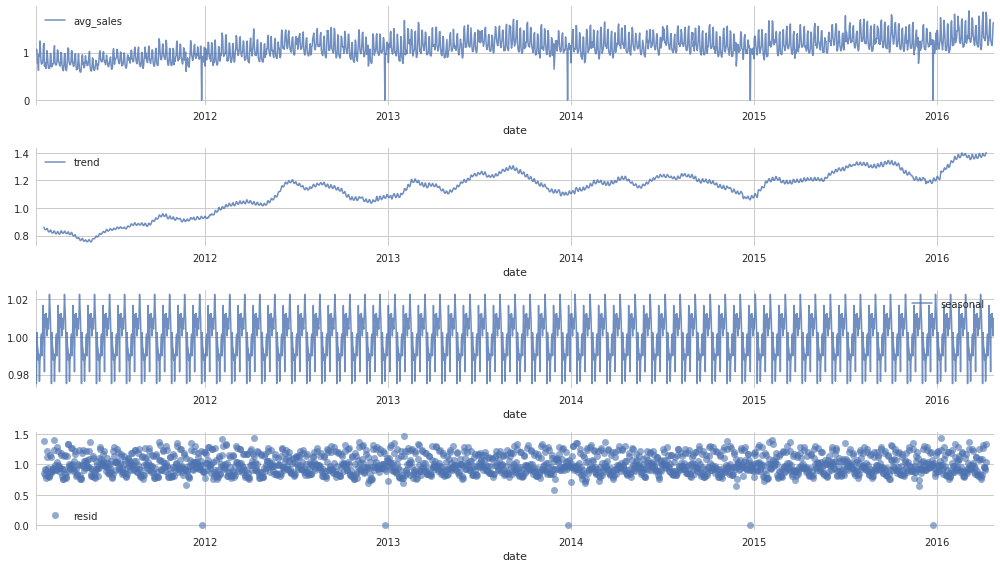

In [ ]:
trend_comp, seas_comp, residual_comp = time_series_decompose(train_sales_cal_df[['avg_sales']], 'multiplicative', 30)

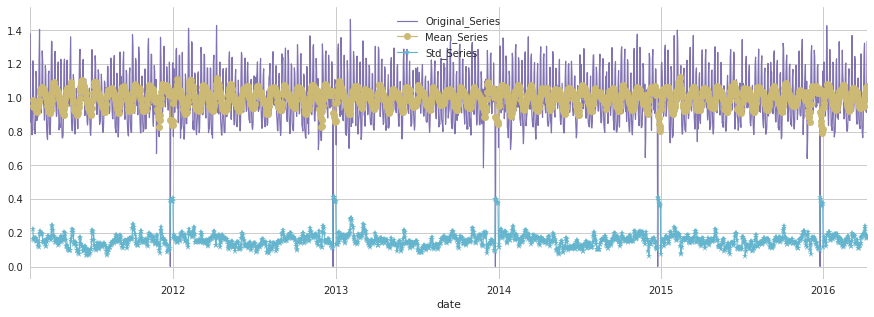


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -26.316735
No of lags: 25.000000
No of Obs used for ADF Calculation & Critical Values: 1857.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
residual_comp = residual_comp.dropna()
time_series_stationary_test(residual_comp)

### SARIMAX

In [ ]:
df_log_diff = np.log(train_sales_cal_df['avg_sales']) - np.log(train_sales_cal_df['avg_sales']).shift()
df_log_diff = df_log_diff.dropna()

#### ACF & PACF: Finding Pdq Visually?

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

def auto_par_corr(ts_stat, nlags=25): 

    '''
    returns the ACF and PACF plots of the time series
    
    inputs: ts_stat (time series along with data), nlags (optimal number of lags)
    
    returns: plot of ACF and PACF
    '''
    lag_acf = acf(ts_stat, nlags)
    lag_pacf = pacf(ts_stat, nlags, method='ols')
    
    sns.set_style("whitegrid")

    
    plt.figure(figsize=(15, 8))
    plt.subplot(121)
    #plt.plot(lag_acf)
    plt.stem(lag_acf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Auto-Correlation')
    
    #lag_pacf.plot(figsize=(15, 5), alpha=1, 
    #                    lw=3, color=next(color_cycle), label='par_corr', ax=ax2)
    plt.subplot(122)
    #plt.plot(lag_pacf)
    plt.stem(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Partial Auto-Correlation')
    
    plt.legend()
    plt.show()

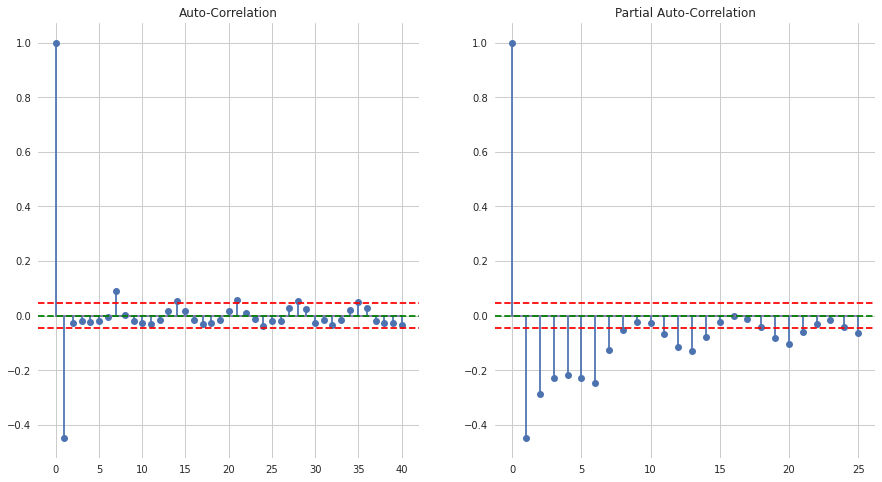

In [ ]:
auto_par_corr(df_log_diff, nlags=25)

In [ ]:
#Let us split the time series into training and testing sets
#perc_training = 0.7
#split_p = round(len(train_sales_cal_df['avg_sales']) * perc_training)
#training_p, testing_p = train_sales_cal_df['avg_sales'][0:split_p], train_sales_cal_df['avg_sales'][split_p:]

training_p = train_sales_cal_df.loc[:'2015-10-14', ['avg_sales']]
testing_p = train_sales_cal_df.loc['2015-10-15':, ['avg_sales']]
training_p.head(2)

,avg_sales
date,
2011-01-29,1.070220
2011-01-30,1.041292


#### Tạo ra các yếu tố không đồng nhất

In [ ]:
df_event_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': calendar_df[~calendar_df['event_name_1'].isna()]['date']})
df_event_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': calendar_df[~calendar_df['event_name_2'].isna()]['date']})
df_snapca = pd.DataFrame({'holiday': 'snap_CA', 'ds': calendar_df[calendar_df['snap_CA'] == 1]['date']})
df_snaptx = pd.DataFrame({'holiday': 'snap_TX', 'ds': calendar_df[calendar_df['snap_TX'] == 1]['date']})
df_snapwi = pd.DataFrame({'holiday': 'snap_WI', 'ds': calendar_df[calendar_df['snap_WI'] == 1]['date']})
holidays = pd.concat((df_event_1, df_event_2, df_snapca, df_snaptx, df_snapwi))
holidays.head(3)

,holiday,ds
8,Event 1,2011-02-06
16,Event 1,2011-02-14
23,Event 1,2011-02-21


In [ ]:
#ever since spliting exo, it is to be added additionally
holidays['ds'] = pd.to_datetime(holidays['ds'])

In [ ]:
# for SARIMAX Model:

data = {'date':train_sales_cal_df.index,
        'holidays': 0 }

exo = pd.DataFrame(data)

for idx, date1 in enumerate(exo['date']):
    for date2 in holidays['ds']:
        if date2 == date1:
            exo['holidays'].iloc[idx] = 1
        else:
            continue       

In [ ]:
exo = exo.set_index(['date']).asfreq('D')
#print (exo)
exo.head(4)

,holidays
date,
2011-01-29,0
2011-01-30,0
2011-01-31,0
2011-02-01,1


In [ ]:
exo_train = exo.loc[:'2015-10-14']
exo_test = exo.loc['2015-10-15':]

In [ ]:
#Conversion into Series according to SARiMAX req:
#conversion into timeseries if required, for now there is neither benefit nor requirement
#exo_train = pd.Series(exo_train.iloc[:, 0])
#exo_test = pd.Series(exo_test.iloc[:, 0])

In [ ]:
def SARIMAX_tune(ts, total_params):

    '''
    returns the optimal tuned results using AIC as a prediction accuracy metric
    
    inputs : ts (time series), total_params (SARIMAX models parameters to be specified)
    
    returns: results of SARIMAX tuned model
    '''
    results = []

    for param in total_params:
        try:
            model = SARIMAX(ts, exog = exo, order=param[0], seasonal_order=param[1], 
                           initialization='approximate_diffuse')
            res = model.fit(method='powell')
            results.append((res, res.aic, res.params))
            print("The results of SARIMAX{}x{} in AIC are: {}".format(param[0], param[1], res.aic))
        except Exception as e:
            print(e)
            continue
    
    return results

In [ ]:
###########New Code#############
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

def SARIMAX_tune_with_RMSE(ts, total_params):
    
    '''
    returns the optimal tuned results using RMSE as a prediction error metric
    
    inputs : ts (time series), total_params (SARIMAX models parameters to be specified)
    
    returns: results of SARIMAX tuned model with RMSE as the error metric
    '''
    tscv = TimeSeriesSplit(n_splits = 5)
    rmse_array = []
    timeseries = ts #train_sales_cal_df[['avg_sales']]
    results = []
    
    for train_index, test_index in tscv.split(timeseries):
        cv_train, cv_test = timeseries.iloc[train_index], timeseries.iloc[test_index]
        
        for param in total_params:
            try:
                model = SARIMAX(cv_train, order=param[0], seasonal_order=param[1], 
                               initialization='approximate_diffuse')
                res = model.fit(method="powell")
                results.append((res, res.params))
                #use this statement for further troubleshooting on mle #print("MLE retvals for this iter are: {}".format(res.mle_retvals))
                #print("The results of SARIMAX{}x{} in are: {}".format(param[0], param[1]))
            except Exception as e:
                print(e)
                continue

            sarimax = model.fit(disp=0)
            predictions = sarimax.predict(cv_test.index.values[0], cv_test.index.values[-1])
            true_values = cv_test.values
            #true_values = cv_test
            #wrmse_array.append(wrmse(true_values, predictions))
            #rmse_array.append(np.sqrt(mean_squared_error(true_values, predictions)))
            print("Results of SARIMAX in {} x {} in RMSE: {}".format(param[0], param[1], 
                                                                 np.sqrt(mean_squared_error(true_values, predictions))))
        
        return results

### The Accuracy Metric AIC: 

Since the **AIC (Akaike-Information Criterion)** is given by the difference of number of paramters vs log-likelihood of the model, it is therefore desirable to select the values of AIC that are as small (or in the current case) as negative as possible. 
The formula for the AIC is :

*  **AIC = 2K - ln(k)**

where k is the number of parameters for the selection of the model

Since the combination for pdq in our case tends to come out as 2,1,1 and for seasonal_PDQ as 0,1,2,7 Therefore, we are going to select those values 

### Validation SARIMAX

In [ ]:
p, d, q =range(1,3), [1], range(1,3)
P, D, Q, S =range(0,3), [1], range(1,3), [7]
pdq = list(itertools.product(p,d,q))
seasonal_pdq = list(itertools.product(P,D,Q,S))
total_params = list(itertools.product(pdq, seasonal_pdq))

#NOTE: memory intensive operation if range set at 0,3, readings have already been taken by running it once:
#all_results = SARIMAX_tune(train_sales_cal_df['avg_sales'], total_params)
#all_results = SARIMAX_tune_with_RMSE(train_sales_cal_df[['avg_sales']], total_params)

#More information regarding fixng the error nle_retvals can be found at:
#https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax

In [ ]:
#all_results = SARIMAX_tune_with_RMSE(train_sales_cal_df[['avg_sales']], total_params)
#######NOTE: THIS WAS THE MISTAKE THAT WAS STOPPING TIMESERIES GRAPHS FROM RENDERGIN#####
#train_sales_cal_df.index = pd.to_datetime(train_sales_cal_df.index)
#type(train_sales_cal_df.index)

                                     SARIMAX Results                                     
Dep. Variable:                         avg_sales   No. Observations:                 1720
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood                1485.773
Date:                           Thu, 20 Oct 2022   AIC                          -2957.546
Time:                                   11:07:44   BIC                          -2919.494
Sample:                               01-29-2011   HQIC                         -2943.457
                                    - 10-14-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3601      0.013     26.946      0.000       0.334       0.386
ar.L2          0.1133      0.022      5.088

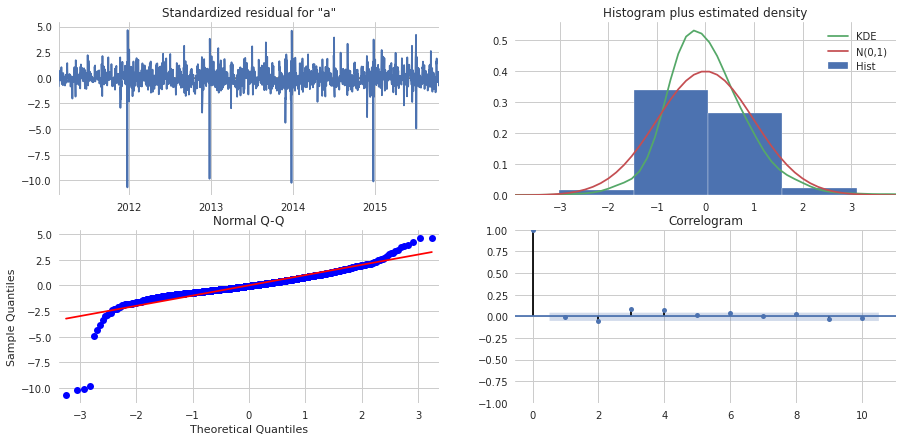

In [ ]:
#Fitting in the SARIMAX Model
#include the exo_train in here , exo_test in prediction (model_fit_SARIMAX) to check results: for now, abandoning their use because
# of the error in package, since even converting exo_train, exo_test into time series/using df results
# in errors. 
#model values earlier 1,1,1, 0,1,1,7 
#values with RMSE - order=(2,1,1), seasonal_order=(2,1,1,7), 
model = SARIMAX(training_p,
                order=(2,1,1), seasonal_order=(2,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(15,7))
plt.show()
#information on whether particular model is a goodfit
#https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

### SARIMAX Graphical Validation & Forecasting

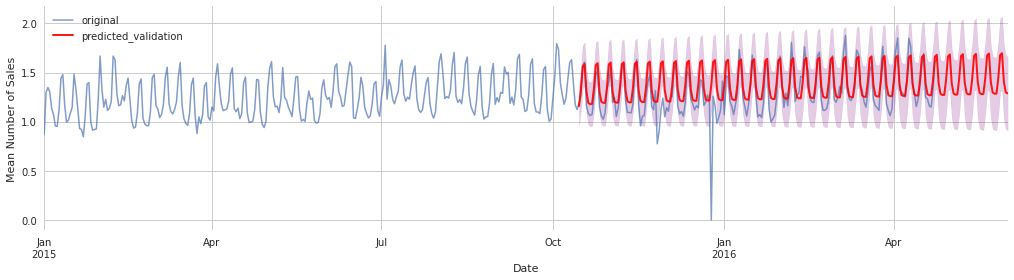

In [ ]:
def model_fit_SARIMAX(model_set, model_fit_srt_tm='2015-10-15', ts_st_tm='2013'):
    
    '''
    makes predictions using SARIMAX model tuned earlier and returns plots along with 
    predictions made
    
    inputs: model_set (model tuned), model_fit_srt_tm (model prediction starting time), 
            ts_st_tm (time series plot to be plotted beginning point)
    returns: forecast plot along with time_series, and pred (predictions made series)
    
    '''
    
    #1.# pred = model_fit.forecast(len(testing_p), alpha=0.05, dynamic=False)  # 95% conf
    pred = model_set.get_prediction(start=pd.to_datetime(model_fit_srt_tm), end='2016-06-01', dynamic=False)
    pred_conf = pred.conf_int()
    #for dynamic prediction of time_series:
    #pred_dy = model_set.get_prediction(dynamic=pred_srt_tm)
    #pred_dy_conf = pred_dy.conf_int()

    # Make as pandas series
    #pred_series = pd.Series(pred, index=testing_p.index)

    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))

    train_sales_cal_df['avg_sales'][ts_st_tm:].plot(label='original',
                                                  alpha=0.7, 
                                                  lw=1.5 , ax=ax1)
    pred.predicted_mean.plot(label='predicted_validation',
                             alpha=0.9, color='red',
                             lw=2, ax=ax1)
    ax1.fill_between(pred_conf.index, 
                     pred_conf.iloc[:,0], 
                     pred_conf.iloc[:, 1], color='purple', alpha=0.2)
    fig.tight_layout()
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Number of Sales')
    plt.legend(loc='upper left')
    plt.show()
    
    return pred

pred_made = model_fit_SARIMAX(model_fit, ts_st_tm='2015')    

In [ ]:
#def forecast_error(prediction, original, date, col):
#    
#    '''
#    returns the Mean Absolute Error (MAE) and root mean square error (RMSE)
#    
#    inputs: prediction (forecasted series, with dates as predicted above), original (orginal time series df), 
#            date (where the model was started for forecast), col(column with time_series_values)
#    
#    returns : MAE, and RMSE 
#    '''
#    forecasted = prediction.predicted_mean
#    original = original.loc[date:, col]
#
#    MAE = np.abs(forecasted - original).mean()
#    RMSE = np.sqrt(((forecasted - original)**2).mean())
#
#    print("The mean absolute error is : {}".format(MAE))
#    print("The root mean square error is : {}".format(RMSE))
#
#
#forecast_error(pred_made, testing_p, '2015-10-15', 'avg_sales')    

In [ ]:
#fitting the model once again now to all the timeseries data (train_sales_cal_df['avg_sales']) available:
#old_values - 2,1,1 & 0,1,2,7
model = SARIMAX(train_sales_cal_df['avg_sales'],
                order=(2,1,1), seasonal_order=(2,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)

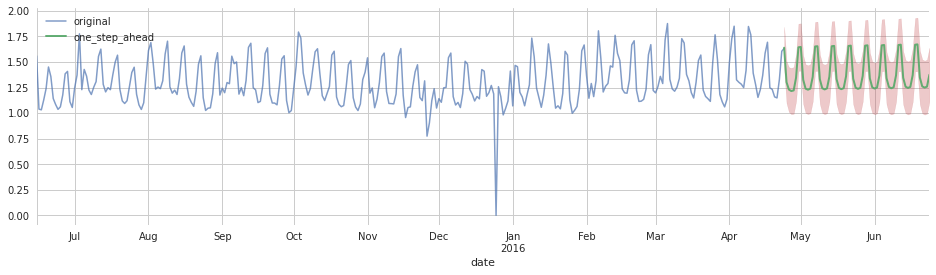

In [ ]:
#Making Future Prediction:
#note: exo_sub = exo.loc['2016-01-25':], if it is needed to provide the holidays , equate exo_sub to exog in get forecast

#pred_future = model_fit.get_forecast(steps=90) #Making Prediction for next 3 months

pred_future = model_fit.get_prediction(start='2016-04-24', end='2016-06-24', dynamic=False)
pred_f_conf = pred_future.conf_int()

fig, ax2 = plt.subplots(figsize=(16, 4))


#now using the entire original series, instead of training or testing:

train_sales_cal_df['avg_sales']['2015-06-15':].plot(label='original',
                 alpha=0.7, 
                 lw=1.5 , color=next(color_cycle), ax=ax2)

pred_future.predicted_mean.plot(label='one_step_ahead',
                 alpha=0.9, 
                 lw=2, color=next(color_cycle), ax=ax2)

ci = pred_f_conf.loc['2016-04-24':]

ax2.fill_between(ci.index, 
                ci.iloc[:,0], 
                ci.iloc[:, 1], color=next(color_cycle), alpha=0.3)

plt.legend(loc='upper left')
plt.show()

### WRMSSE Calculation

In order to measure the performance of the model, the competition metric has been provided already. This competiton metric can be found at the guidlines provided in the following link. 

WRMSSE is a sales metric that derives itself from RMSSE metric which is a variation on the metric of MASE (mean absolute scaled error). RMSSE specifically evaluate the sales forecast for datasets where heirarchical data level is made available. Since the first dataset of train_sales_val has heirarchical sales data available (i.e.sales divided along product_ids, item_ids, dept_ids, and store_ids level) and one that is also intermittent (i.e. has greater incidence of zero sales in some days while significant sales in other days), RMSSE's utility makes sense. The RMSSE metric also penalizes too large or too small values, therefore it is symmetric. 

\begin{equation}
WRMSSE = \sum_{i=1}^{42840} \left(\frac{W_i}{\sqrt{S_i}} \times \sqrt{\sum{(D)^2}}\right)
\end{equation}

Note: Difference in rolled up vectors is equal to their rolled up difference:
\begin{equation}
Y×M−Y^×M=(Y−Y^)×M=D
\end{equation}

where Y_t is the actual future value of the examined time series at point t, (Y_t ) is the generated forecast, n the length of the training sample (number of historical observations), and h the forecasting horizon. 


In [ ]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

calendar_df = reduce_mem_usage(calendar_df)

sell_prices_df = reduce_mem_usage(sell_prices_df)

Mem. usage decreased to  0.12 Mb (0.0% reduction)
Mem. usage decreased to 182.68 Mb (0.0% reduction)


In [ ]:
from scipy.sparse import csr_matrix
import gc

NUM_ITEMS = train_sales_df.shape[0]  # 30490
DAYS_PRED = submission_file.shape[1] - 1  # 28

# Dataframe with only last 28 days:
sales = train_sales_df
cols = ["d_{}".format(i) for i in range(1914-28, 1914)]
data = sales[["id", 'store_id', 'item_id'] + cols]

# To long form:
data = data.melt(id_vars=["id", 'store_id', 'item_id'], 
                 var_name="d", value_name="sale")

# Add week of year column from 'calendar':
data = pd.merge(data, calendar_df, how = 'left', 
                left_on = ['d'], right_on = ['d'])

data = data[["id", 'store_id', 'item_id', "sale", "d", "wm_yr_wk"]]

# Add weekly price from 'sell_prices':
data = data.merge(sell_prices_df, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
data.drop(columns = ['wm_yr_wk'], inplace=True)

# Calculate daily sales in USD:
data['sale_usd'] = data['sale'] * data['sell_price']
data.head()

#this part is correct

,id,store_id,item_id,sale,d,sell_price,category,sale_usd
0,HOBBIES_1_001_CA_1_validation,CA_1,HOBBIES_1_001,1,d_1886,8.257812,HOBBIES,8.257812
1,HOBBIES_1_002_CA_1_validation,CA_1,HOBBIES_1_002,1,d_1886,3.970703,HOBBIES,3.970703
2,HOBBIES_1_003_CA_1_validation,CA_1,HOBBIES_1_003,0,d_1886,2.970703,HOBBIES,0.000000
3,HOBBIES_1_004_CA_1_validation,CA_1,HOBBIES_1_004,0,d_1886,4.640625,HOBBIES,0.000000
4,HOBBIES_1_005_CA_1_validation,CA_1,HOBBIES_1_005,1,d_1886,2.880859,HOBBIES,2.880859


In [ ]:
# List of categories combinations for aggregations as defined in docs:
dummies_list = [sales.state_id, sales.store_id, 
                sales.cat_id, sales.dept_id, 
                sales.state_id +'_'+ sales.cat_id, sales.state_id +'_'+ sales.dept_id,
                sales.store_id +'_'+ sales.cat_id, sales.store_id +'_'+ sales.dept_id, 
                sales.item_id, sales.state_id +'_'+ sales.item_id, sales.id]


## First element Level_0 aggregation 'all_sales':
dummies_df_list =[pd.DataFrame(np.ones(sales.shape[0]).astype(np.int8), 
                               index=sales.index, columns=['all']).T]

# List of dummy dataframes:
for i, cats in enumerate(dummies_list):
    dummies_df_list +=[pd.get_dummies(cats, drop_first=False, dtype=np.int8).T]
    
# Concat dummy dataframes in one go:
## Level is constructed for free.
roll_mat_df = pd.concat(dummies_df_list, keys=list(range(12)), 
                        names=['level','id'])#.astype(np.int8, copy=False)

# Save values as sparse matrix & save index for future reference:
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
roll_mat_csr.shape

(42840, 30490)

In [ ]:
roll_mat_df.to_pickle('roll_mat_df.pkl')
del dummies_df_list, roll_mat_df
gc.collect()

17763

In [ ]:
# Fucntion to calculate S weights:
def get_s(drop_days=0):
    
    """
    drop_days: int, equals 0 by default, so S is calculated on all data.
               If equals 28, last 28 days won't be used in calculating S.
    """
    # Rollup sales:
    d_name = ['d_' + str(i+1) for i in range(1913-drop_days)]
    sales_train_val = roll_mat_csr * sales[d_name].values

    no_sales = np.cumsum(sales_train_val, axis=1) == 0
    sales_train_val = np.where(no_sales, np.nan, sales_train_val)

    # Denominator of RMSSE / RMSSE
    weight1 = np.nanmean(np.diff(sales_train_val,axis=1)**2,axis=1)
    
    return weight1

In [ ]:
S = get_s(drop_days=0)
S.shape

(42840,)

In [ ]:
# Functinon to calculate weights:
def get_w(sale_usd):
    """
    """
    # Calculate the total sales in USD for each item id:
    total_sales_usd = sale_usd.groupby(
        ['id'], sort=False)['sale_usd'].apply(np.sum).values
    
    # Roll up total sales by ids to higher levels:
    weight2 = roll_mat_csr * total_sales_usd
    
    return 12*weight2/np.sum(weight2)

In [ ]:
W = get_w(data[['id','sale_usd']])
W.shape

(42840,)

In [ ]:
# Predicted weights
##W_df = pd.DataFrame(W,index = roll_index,columns=['w'])

# Load the original weights:
##data_pass = '/kaggle/input/original-weights/'
##W_original_df = pd.read_csv(data_pass+'weights_validation.csv')

# Set new index, calculate difference between original and predicted:
##W_original_df = W_original_df.set_index(W_df.index)
##W_original_df['Predicted'] = W_df.w
##W_original_df['diff'] = W_original_df.Weight - W_original_df.Predicted

# See where we are off by more than e-6
##m = W_original_df.Weight.values - W_df.w.values > 0.000001
##W_original_df[m]

In [ ]:
SW = W/np.sqrt(S)
sw_df = pd.DataFrame(np.stack((S, W, SW), axis=-1),index = roll_index,columns=['s','w','sw'])
sw_df.to_pickle('sw_df.pkl')

ValueError: ignored

In [ ]:
# Function to do quick rollups:
def rollup(v):
    '''
    v - np.array of size (30490 rows, n day columns)
    v_rolledup - array of size (n, 42840)
    '''
    return roll_mat_csr*v #(v.T*roll_mat_csr.T).T


# Function to calculate WRMSSE:
def wrmsse(preds, y_true, score_only=False, s = S, w = W, sw=SW):
    '''
    preds - Predictions: pd.DataFrame of size (30490 rows, N day columns)
    y_true - True values: pd.DataFrame of size (30490 rows, N day columns)
    sequence_length - np.array of size (42840,)
    sales_weight - sales weights based on last 28 days: np.array (42840,)
    '''
    
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds.values-y_true.values))
                            ,axis=1)) * sw)/12 #<-used to be mistake here
    else: 
        score_matrix = (np.square(rollup(preds.values-y_true.values)) * np.square(w)[:, None])/ s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix,axis=1)))/12 #<-used to be mistake here
        return score, score_matrix

### **Prophet Time Series Modeling**
Prophet is a time-series forecasting tool developed by facebook team that has advanced capabilities to predict the time series data taking into consideration the weekly, monthly or yearly data seasonality. Prophet also has advanced capability to implement custom changepoints observed in time series data as well as specify holiday points where trends are continuously changing.

In [ ]:
#dates_s = [pd.to_datetime(calendar_df.loc[calendar_df['d'] == str_date,'date'].values[0]) for str_date in d_cols]

In [ ]:
#df_sale_group_item = train_sales_df[np.hstack([['dept_id','store_id'],d_cols])].groupby(['dept_id','store_id']).sum()
#df_sale_group_item = df_sale_group_item.reset_index()

#item_series =  df_sale_group_item[(df_sale_group_item.dept_id == 'FOODS_1') & (df_sale_group_item.store_id == 'TX_1')]
#dates = pd.DataFrame({'ds': dates_s}, index=range(len(dates_s)))
#dates['y'] = item_series[d_cols].values[0].transpose() 

### Fb Prophet: Training and Validation Data Split

In [ ]:
#prophet forecast from here
from fbprophet import Prophet
from tqdm.notebook import tqdm as tqdm

####Observing behavior of Avg Number of Sales using Prophet#######
####Converting the data into required ds and y format for Prophet Model#####

ts = train_sales_cal_df[['avg_sales']].reset_index()
ts = ts.set_axis(['ds', 'y'], axis=1, inplace=False)

#####Specifying data for only one year to better visulize future predictions#######
threshold_date = pd.to_datetime('2015-04-22') 
select_d = ts['ds'] > threshold_date.strftime("%Y/%m/%d")

ts = ts[select_d][['ds', 'y']]

#####prophet_plot(ts)######

mod_params = { 'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 
sales_model = Prophet(**mod_params, interval_width=0.95)
#data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used

######fitting the prophet model########

sales_model.fit(ts)
future = sales_model.make_future_dataframe(28, 'D')
#future['cap'] = data['cap'].max() #incase logistic model growth used in params
sales_forecast = sales_model.predict(future)

########Train/Test split of Data#######################

threshold_date = pd.to_datetime('2016-03-01') #for the test/validation split
forecast_date = pd.to_datetime('2016-04-24') #for the actual forecast date to begin
select_d = ts ['ds'] < threshold_date.strftime("%Y/%m/%d")

ts_train = ts[select_d][['ds', 'y']]
ts_test = ts[~ select_d][['ds', 'y']]

select_d2 = sales_forecast['ds'] < forecast_date


forecast_train = sales_forecast[select_d2]
forecast_test = sales_forecast[~ select_d2]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Prophet Forecasting On Average Sales Using Seaborn

In [ ]:
#Seaborn based plot for the fb_Prophet Model
sns.set_style('whitegrid')
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(15,5))

ax.fill_between(
    x=sales_forecast['ds'], y1=sales_forecast['yhat_lower'], y2=sales_forecast['yhat_upper'],
    color=sns_c[2],  alpha=0.25, label=r'95% confidence_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=ts_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=ts_test, ax=ax)
#sns.lineplot(x='ds', y='yhat', label='y_hat', data=sales_forecast, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.axvline(forecast_date, color='g', linestyle='--', label='train test split')

ax.legend(loc='lower left')
ax.set(title='Avg Sales of Units', ylabel='');

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f7e56208710> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1080x360 with 1 Axes>

### Prophet Forecast Using Individual Product IDs

In [ ]:
#selecting the product ids for which we require prophet prediction

id1 = 'FOODS_3_443_CA_1_validation'
id2 =  'HOUSEHOLD_1_005_CA_3_validation'
id3 =  'FOODS_3_823_WI_3_validation'
id4 = 'FOODS_3_090_CA_3_validation'
id5 = 'FOODS_3_586_TX_2_validation'
id6 = 'FOODS_3_586_TX_3_validation'

#train_sales_cal_df[id2]

In [ ]:
def make_id_timeseries(idx, date='2016-02-22'):
    
    '''
    selects and makes the timeseries adjusted for fb prophet model by adjusting names
    of columns
    
    inputs: product_id
    
    returns: time series with data specified in format for prophet
    
    '''
    
    dates_series = [date for date in train_sales_cal_df.index]
    id_series =  train_sales_df[(train_sales_df.id == idx )]
    item_ts = pd.DataFrame({'ds': dates_series}, index=range(len(dates_series)))
    item_ts['y'] = id_series[d_cols].values[0].transpose()
    
    ######Following steps would shorten the behavior of historic timeline data########
    ######Choosing the threshold date near to the date where prediction needs to be made 
    ######because of close correlation in time series
    
    threshold_date = pd.to_datetime(date) 
    mask = item_ts['ds'] > threshold_date.strftime("%Y/%m/%d")

    item_ts = item_ts[mask][['ds', 'y']]
    
    return item_ts

data1 = make_id_timeseries(id6)
data4 = make_id_timeseries(id4)

In [ ]:
#weighted_coeff = (df_cv['yhat'] - df_cv['y'])/(df_cv['yhat'] - df_cv['y']).mean()
#e = ((df_cv['yhat'] - df_cv['y']) * weighted_coeff )/ (weighted_coeff*df_cv['y'])
#resulting_wmape = pd.DataFrame(df_cv['yhat'], df_cv['y'], weighted_coeff, e)
##print("yhat:{}, actual:{}, coeff:{}, error:{}".format(df_cv['yhat'], df_cv['y'], weighted_coeff, e))
#data = {'yhat':list(df_cv['yhat']),
#        'actual':list(df_cv['y']),
#        'diff' : list(df_cv['yhat'] - df_cv['y']),
#       'weighted_coef': list(weighted_coeff), 
#       'error': list(e)}
#  
# Create DataFrame
#pd.DataFrame(data)

### Custom Loss Function For Fb Prophet Tuning

In [ ]:
##########New Code Working For Custom Error###########
import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Note : the code was generated using the explanation at the following link
#https://www.baeldung.com/cs/mape-vs-wape-vs-wmape

def fbprophet_tuning_per_single_id(id_data, changepoint_prior_list=[0.5, 0.6, 0.7], 
                                   changepoint_range_list=[0.6, 0.7, 0.8], 
                                   n_changepoints_list=[50, 60]):
    param_grid = {  
        'changepoint_prior_scale': changepoint_prior_list,
        'changepoint_range': changepoint_range_list,
        'n_changepoints' : n_changepoints_list
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    #wapes = []  # Store the RMSEs for each params here
    wmapes = []

    # Use cross validation to evaluate all parameters
    for params in all_params:
        mod = Prophet(**params).fit(id_data)  # Fit model with given params
        df_cv = cross_validation(mod, initial = '32 days', period = '3 days', horizon='28 days')
        #df_p = performance_metrics(df_cv, rolling_window=1)
        #rmses.append(df_p['rmse'].values[0])
        #wapes.append(np.sum(df_cv['yhat'] - df_cv['y']) / (np.sum(df_cv['y'])))
        weighted_coeff = (df_cv['yhat'] - df_cv['y'])/(df_cv['yhat'] - df_cv['y']).mean()
        wmapes.append(np.sum((df_cv['yhat'] - df_cv['y']) * weighted_coeff )/ np.sum(weighted_coeff*df_cv['y']) )

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['wmape'] = wmapes
    print(tuning_results)
    
fbprophet_tuning_per_single_id(data1)  

ValueError: ignored

In [ ]:
def prophet_plot(data, periods=28, freq='D'):
    
    '''
    plots the fb prophet model for the data of id specified
    
    inputs: data (product id along with data for previous days), periods(predictions for 
    the next days to be made)
    
    returns: plots the immediate historic data along with forecast for the future made
    '''
    
    mod_params = { 'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 

    sales_model = Prophet(**mod_params, holidays=holidays, interval_width=0.95)
    #data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used
    #fitting the model
    sales_model.fit(data)
    future = sales_model.make_future_dataframe(periods, freq)
    #future['cap'] = data['cap'].max() #incase logistic model growth used in params

    sales_forecast = sales_model.predict(future)
    
    plt.figure(figsize=(15,3))
    #fig, ax = plt.subplots(figsize=(14,5))
    sales_model.plot(sales_forecast, xlabel='Date', ylabel='Unit Sales Behavior')
    #plt.axvline(x=sales_forecast[sales_forecast.ds == '2016-04-22']['ds'], color='r')
    #ax.axvline(threshold_date, color='g', linestyle='--', label='Prediction Onwards')
    #ax.legend(loc='upper left')
    #ax.set(title='Avg Sales of Units', ylabel='');
    plt.title("Unit Sales Trend on Each ID")
    plt.show()


prophet_plot(data1)
prophet_plot(data4)    

ValueError: ignored

In [ ]:
all_ids = train_sales_cal_df.columns.drop(['daysnum', 'avg_sales'])
sales_forecast_list = []

def prophet_pred_df(start=15500, end=15650):
    '''
    makes a dataframe with prophet predictions made for each product_id 
    
    input: start = product_id start, end = product_id to be the last one for prediction
    
    returns: dataframe with predictions made for the next 28 days using prophet of the product
             ids specified in input
    '''

    for idc in tqdm(range(start, end)):
        train_sub = train_sales_cal_df.iloc[-28:, idc].reset_index()
        idx = train_sub.columns[1]
        train_sub.set_axis(['ds', 'y'], axis=1, inplace=True)
        mod_params = { 'changepoint_prior_scale': 0.5 , 'changepoint_range': 0.6,
                      'n_changepoints': 50, 
                      'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 
        sales_model = Prophet(**mod_params, interval_width=0.95)
        #data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used

        ######fitting the prophet model########
        
        sales_model.fit(train_sub)
        future = sales_model.make_future_dataframe(28, 'D')
        #future['cap'] = data['cap'].max() #incase logistic model growth used in params
        sales_forecast = sales_model.predict(future)[-28:]
        sales_forecast_list.append( (np.append(np.array([idx]), sales_forecast['yhat'].values.transpose())) )
    
    return sales_forecast_list

#list_table would collect all entries

list_table = prophet_pred_df()

  0%|          | 0/150 [00:00<?, ?it/s]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

In [ ]:
#changing column names to those as specified in submission file
df_prophet_forecast = pd.DataFrame(list_table)
df_prophet_forecast.columns = submission_file.columns
#df_prophet_forecast = df_prophet_forecast.round(decimals = 2)
df_prophet_forecast.head(6)

In [ ]:
########Remove Unwanted Columns###################
train_sales_df = train_sales_df.drop(['total_sales_all_days', 'avg_sales_all_days', 'median_sales_all_days'], axis=1)

###########Making the dataframe of predictions for all ids############
req_sales_df = train_sales_df.iloc[:, np.r_[0,-28:0]].melt('id', var_name='d', value_name='sale')
req_sales_df = req_sales_df.merge(calendar_df.loc[:,['d','date','wday']])
#req_sales_df
lastest_date = int(req_sales_df.d.max()[2:])
req_sales_df = req_sales_df.groupby(['id','wday'])['sale'].mean()
req_sales_df.head(7)

In [ ]:
###########Generating Submission Dataframe of ids for 28 next days with 0 values############

mv_avg_forecast = submission_file.copy()
mv_avg_forecast.columns = ['id'] + ['d_' + str(lastest_date + x) for x in range(1, 29)]
mv_avg_forecast = mv_avg_forecast.loc[mv_avg_forecast.id.str.contains('validation')]
#mv_avg_forecast

In [ ]:
###########Generating Dataframe for Moving Average Values###############

mv_avg_forecast = mv_avg_forecast.melt('id', var_name='d', value_name='sale')
mv_avg_forecast = mv_avg_forecast.drop('sale',axis = 1)
#mv_avg_forecast

mv_avg_forecast = mv_avg_forecast.merge(calendar_df.loc[:,['d','date','wday']])
mv_avg_forecast = mv_avg_forecast.join(req_sales_df, on=['id', 'wday'])
#mv_avg_forecast

mv_avg_forecast = mv_avg_forecast.pivot(index='id', columns='d', values='sale')
mv_avg_forecast = mv_avg_forecast.reset_index()
mv_avg_forecast

In [ ]:
#del mv_avg_forecast.index.name
mv_avg_forecast.rename_axis(None).index.name
mv_avg_forecast.head(4)

In [ ]:
#df_sub_valid = pd.concat([mv_avg_forecast, df_prophet_forecast_1, 
#                        df_prophet_forecast_2,df_prophet_forecast_3, 
#                        df_prophet_forecast_4, df_prophet_forecast_5, 
#                        df_prophet_forecast_6], sort=False)

#re-adjusting the old columns against new-ones

mv_avg_forecast.columns = submission_file.columns

df_valid = pd.concat([mv_avg_forecast[~mv_avg_forecast.id.isin(df_prophet_forecast.id)], df_prophet_forecast], sort=False)

df_eval = df_valid.copy()
df_eval['id'] = df_eval['id'].str.replace("validation", "evaluation")

submission_df = pd.concat([df_valid, df_eval], sort=False)
submission_df = submission_df.sort_values('id')

In [ ]:
submission_df.columns

In [ ]:
#submission_df.columns = ['id'] + ['F' + str(x) for x in range(1, 29)]
#submission_df

### WRMSSE Error Calculation on Prediction

In [ ]:
#DAYS_PRED = 28
dayCols = ["d_{}".format(i) for i in range(1914-DAYS_PRED, 1914)]
y_true = train_sales_df[dayCols]

In [ ]:
df_valid_w = df_valid.drop('id', 1)
for col in df_valid_w.columns:
    df_valid_w[col] = pd.to_numeric(df_valid_w[col], errors='coerce')#.convert_dtypes() cp95 solution recommends using convertdtypes if nan present

In [ ]:
wrmsse(y_true, df_valid_w, score_only=True)

### Final Submission File Preparation

In [ ]:
# Fix negative forecast
num = submission_df._get_numeric_data()
num[num < 0] = 0
# Prepare the submission file
submission_df.to_csv('submission.csv', index=False)

print(f'Submission shape: {submission_df.shape}')

In [ ]:
#kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "from 450 to 600"

## Further Recommendations on Improvement

Usingh the prophet model along with a general moving average prediction for rest of the ids not predicted using prophet model were used to make forecast for the next 28 days. However, the accuracy score from kaggle private leaderboard has come out to be around 0.73. There are a few other kernels that have described ways to improve this further

Please Feel Free to Improve Upon this notebook and give your feedback

- Run the model of prophet forecast for atleast 1/3rd of the all product ids to explore its potential of improving the forecast , using a fast machine.
- Use another model implementation such as LightGBM, Convolution NN to improve the score
- Make new features with rolling mean as well as a lag feature that have been observed to improve score when using models such as lightgbm

## References and Further Readings:

Quite a few resources proved helpful while others that offered more opportunity for learning are mentioned below

- https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- https://towardsdatascience.com/time-series-forecasting-a-getting-started-guide-c435f9fa2216
- https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
- https://facebook.github.io/prophet/docs/diagnostics.html
- https://www.baeldung.com/cs/mape-vs-wape-vs-wmape
- https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/144067
- Special thanks to the kernel of TSURU https://www.kaggle.com/girmdshinsei/for-japanese-beginner-with-wrmsse-in-lgbm#WRMSSE-calculation
- Specal thanks to the kernel of sibmike for making WRMSSE calculation faster https://www.kaggle.com/mubashir1/fast-clear-wrmsse-18ms/edit
- https://www.kaggle.com/binhlc/forecasting-multiple-time-series-using-prophet
- https://www.kaggle.com/tnmasui/m5-wrmsse-evaluation-dashboard